# BTC ML/DL Trading strategy

In [1]:
import sys, os, ipynbname
NOTEBOOK_NAME = f"{ipynbname.name()}.ipynb"
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(NOTEBOOK_NAME), os.path.pardir)))

In [125]:
from src.Utils import *
import talib as ta

## Preliminary data import & handling

In [126]:
# Importing Bitcoin pre-processed financial data
df = pq.read_pandas(source=f"{Utils.ASSETS_FOLDER}/parquet/{Utils.get_asset_id('Bitcoin')}.parquet").to_pandas()

In [127]:
# Deepcopying
df_ = df.copy(deep=True)

In [128]:
df.head()

,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
2018-01-01 00:01:00,229,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093
2018-01-01 00:02:00,235,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591
2018-01-01 00:03:00,528,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014
2018-01-01 00:04:00,435,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101
2018-01-01 00:05:00,742,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842


In [129]:
# Resampling to 10-min bins
df = df.resample("10T").agg({
    "Count": "median",
    "Open": "first",
    "High": "max",
    "Low": "min",
    "Close": "last",
    "Volume": "mean",
    "VWAP": "mean"
})

# Removing NaN and broadcasting it to `Count`
df["Count"] = pd.to_numeric(arg=df["Count"], downcast="integer")
df.fillna(method="ffill", inplace=True)

In [130]:
# Displaying first rows
df.head()

,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
2018-01-01 00:00:00,437.0,13835.194,14052.3,13501.01,13720.260,60.545301,13756.177556
2018-01-01 00:10:00,301.0,13713.610,13948.6,13400.01,13626.110,49.918511,13665.050348
2018-01-01 00:20:00,308.0,13626.248,13826.8,13410.44,13648.280,53.002165,13623.876888
2018-01-01 00:30:00,228.5,13638.620,13800.0,13461.74,13636.600,36.841839,13652.429477
2018-01-01 00:40:00,245.0,13649.296,13800.0,13450.00,13693.004,48.451182,13640.833680


In [131]:
# Some statistical analysis
df.describe()

,Count,Open,High,Low,Close,Volume,VWAP
count,213697.000000,213697.000000,213697.00000,213697.000000,213697.000000,213697.000000,213697.000000
mean,1036.576513,18706.849749,18780.56934,18636.490999,18706.957875,89.569992,18706.905950
std,1279.366497,17863.740695,17904.31739,17814.076681,17863.725874,114.678819,17863.725563
min,1.000000,3153.860000,3232.60000,3120.000000,3160.405000,0.001104,3159.199122
25%,318.000000,7124.448333,7159.00000,7098.480000,7124.657143,36.544792,7124.256692
50%,614.000000,9504.030000,9530.00000,9476.660000,9503.897143,57.727493,9503.429433
75%,1311.500000,32225.492857,32361.00000,32084.715549,32225.264388,98.577041,32221.782272
max,55717.500000,68716.598333,69024.20000,68447.000000,68724.006667,3985.862343,68619.267512


## Data aggregation

We are encouraged to add:
- additional metrics (RSI, moving averages, ...) and indicators from technical analysis
- additional data sources (from historical data API including FTX or Binance APIs)
- use of resampling routine to:
    - identify patterns
    - reduce the length of our data sample

### Log-returns & Day-time range

In [132]:
# Adding the daytime range for each line
try:
    df_t = [obs.hour for obs in list(df.index)]
    df["TimeRange"] = [Utils.get_daytime_range(time_) for time_ in df_t]
except KeyError:
    pass

In [133]:
# Computing log-returns
df["LogReturns"] = np.log(df["Close"]).diff()
df["LogReturns"].fillna(0, inplace=True)

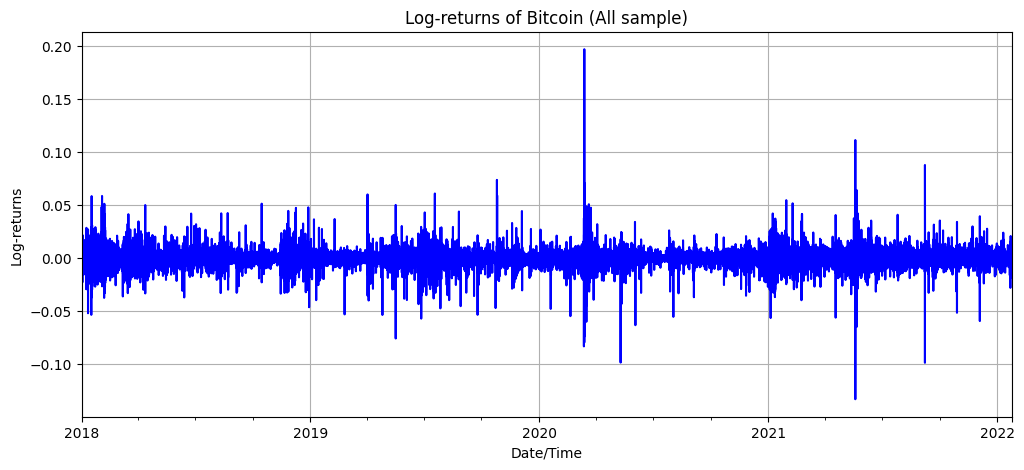

In [134]:
# Plotting log-returns
_ = df["LogReturns"].plot()
_ = plt.title("Log-returns of Bitcoin (All sample)")
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Log-returns")
_ = plt.grid()

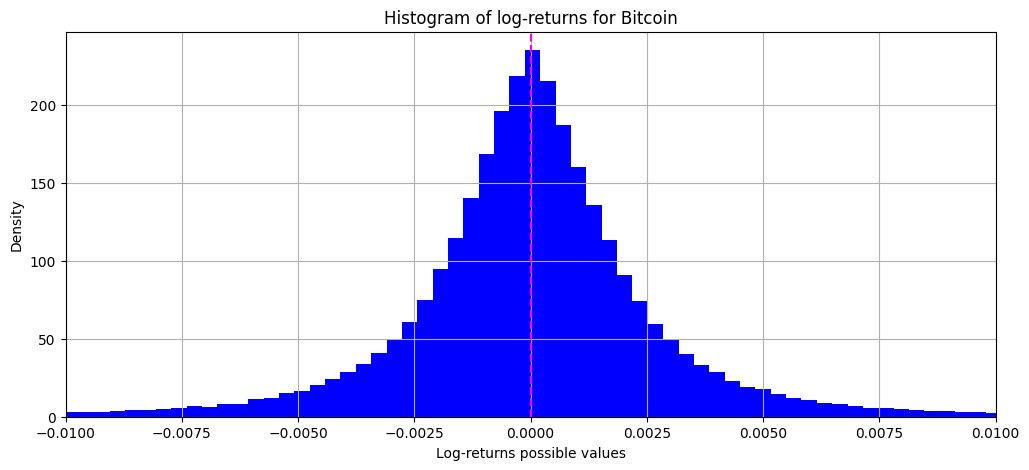

In [135]:
# Plotting log-returns
_ = df["LogReturns"].hist(bins=1000, density=True)
_ = plt.xlim([-0.01, 0.01])
_ = plt.title("Histogram of log-returns for Bitcoin")
_ = plt.xlabel("Log-returns possible values")
_ = plt.axvline(x = 0, color="magenta", ls="--")
_ = plt.ylabel("Density")

### Technical analysis indicators & Moving averages

In [136]:
df["Target"] = np.where(df["Close"].shift(-1) > df["Close"], 1, 0)

In [137]:
def rsi(df, periods = 10, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    # Computing the Close price delta
    close_delta = df["Close"].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
        # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
    
    # Computing the RSI
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [17]:
try:
    df.drop(["Open", "High", "Low"], inplace=True, axis=1)
except KeyError:
    pass
df.head()

,Count,Close,Volume,VWAP,TimeRange,LogReturns
timestamp,,,,,,
2018-01-01 00:00:00,437.0,13720.260,60.545301,13756.177556,5,0.000000
2018-01-01 00:10:00,301.0,13626.110,49.918511,13665.050348,5,-0.006886
2018-01-01 00:20:00,308.0,13648.280,53.002165,13623.876888,5,0.001626
2018-01-01 00:30:00,228.5,13636.600,36.841839,13652.429477,5,-0.000856
2018-01-01 00:40:00,245.0,13693.004,48.451182,13640.833680,5,0.004128


In [138]:
# Computing Rolled average close price
df["Rolled_Avg_Close"] = df["Close"].rolling(window=10).mean()

# Computing correlation
df["Corr"] = df["Close"].rolling(window=10).corr(df["Rolled_Avg_Close"])

# Computing Open-Close indicator
df["Open-Close"] = df["Open"] - df["Close"].shift(1)

# Computing Open-Open indicator
df["Open-Open"] = df["Open"] - df["Open"].shift(1)

# Computing the RSI () indicator
df["RSI"] = rsi(df)

# Computing the Bollinger Bands (BB) indicators
upper_2sd, mid_2sd, lower_2sd = ta.BBANDS(df["Close"], 
                                          nbdevup=2,
                                          nbdevdn=2,
                                          timeperiod=20)
df["BBANDS_U"] = upper_2sd
df["BBANDS_M"] = mid_2sd
df["BBANDS_L"] = lower_2sd

# Computing SMA moving averages for various time windows
df["SMA_SLOW"] = ta.SMA(df["Close"], timeperiod=5)
df["SMA_MEDIUM"] = ta.SMA(df["Close"], timeperiod=10)
df["SMA_FAST"] = ta.SMA(df["Close"], timeperiod=15)

In [139]:
# Getting DataFrame shape
df_shape_before = df.shape[0]

# Dropping newly-created NaN values
df.dropna(inplace=True)

# Getting DataFrame shape
df_shape_after = df.shape[0]

# Getting number of deletedrows
abs(df_shape_after - df_shape_before)

19

In [140]:
# Displaying DataFrame
df.head()

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,Target,...,Corr,Open-Close,Open-Open,RSI,BBANDS_U,BBANDS_M,BBANDS_L,SMA_SLOW,SMA_MEDIUM,SMA_FAST
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 03:10:00,352.5,13417.998,13830.0,13346.75,13543.918,68.009210,13494.833017,5,0.009403,1,...,-0.380974,0.832,7.750,54.431361,13775.309957,13518.7868,13262.263643,13427.1296,13403.3596,13470.098800
2018-01-01 03:20:00,244.5,13545.052,13888.0,13428.03,13627.612,49.965753,13584.533490,5,0.006160,0,...,-0.556381,1.134,127.054,60.915374,13759.039247,13514.1544,13269.269553,13489.6124,13423.3538,13468.838667
2018-01-01 03:30:00,326.0,13633.470,13898.9,13400.00,13563.692,40.981728,13624.720631,5,-0.004702,0,...,-0.475076,5.858,88.418,54.352457,13751.685971,13511.0335,13270.381029,13513.1720,13446.0278,13469.692000
2018-01-01 03:40:00,168.0,13561.794,13798.5,13440.00,13549.480,25.024610,13570.538872,5,-0.001048,0,...,-0.490321,-1.898,-71.676,52.943308,13739.212147,13506.0935,13272.974853,13540.3736,13459.2326,13463.470800
2018-01-01 03:50:00,272.5,13546.378,13787.2,13360.00,13496.986,39.879553,13502.166655,5,-0.003882,0,...,-0.349084,-3.102,-15.416,47.851783,13724.411675,13499.1128,13273.813925,13556.3376,13472.1920,13455.853200


In [17]:
# Momentum
# Standard deviation
# ...

### External data sources (e.g. Binance, Coinbase, FTX, ...)

$\longrightarrow$ Potential extension (10-min data of **S&P 500**, **DJIA**)

## Data pre-processing

In [141]:
df.head()

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,Target,...,Corr,Open-Close,Open-Open,RSI,BBANDS_U,BBANDS_M,BBANDS_L,SMA_SLOW,SMA_MEDIUM,SMA_FAST
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 03:10:00,352.5,13417.998,13830.0,13346.75,13543.918,68.009210,13494.833017,5,0.009403,1,...,-0.380974,0.832,7.750,54.431361,13775.309957,13518.7868,13262.263643,13427.1296,13403.3596,13470.098800
2018-01-01 03:20:00,244.5,13545.052,13888.0,13428.03,13627.612,49.965753,13584.533490,5,0.006160,0,...,-0.556381,1.134,127.054,60.915374,13759.039247,13514.1544,13269.269553,13489.6124,13423.3538,13468.838667
2018-01-01 03:30:00,326.0,13633.470,13898.9,13400.00,13563.692,40.981728,13624.720631,5,-0.004702,0,...,-0.475076,5.858,88.418,54.352457,13751.685971,13511.0335,13270.381029,13513.1720,13446.0278,13469.692000
2018-01-01 03:40:00,168.0,13561.794,13798.5,13440.00,13549.480,25.024610,13570.538872,5,-0.001048,0,...,-0.490321,-1.898,-71.676,52.943308,13739.212147,13506.0935,13272.974853,13540.3736,13459.2326,13463.470800
2018-01-01 03:50:00,272.5,13546.378,13787.2,13360.00,13496.986,39.879553,13502.166655,5,-0.003882,0,...,-0.349084,-3.102,-15.416,47.851783,13724.411675,13499.1128,13273.813925,13556.3376,13472.1920,13455.853200


In [ ]:
# Computation of the target

In [25]:
# Normalization (see YouTube)

In [ ]:
# X/Y split

In [ ]:
# Train/Test/Validation split

In [142]:
from backtesting import Strategy
import xgboost

In [6]:
xgboost.build_info

<function xgboost.core.build_info() -> dict>

In [143]:
btc_2018 = df["2018": "2019"]

In [144]:
btc_2018

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,Target,...,Corr,Open-Close,Open-Open,RSI,BBANDS_U,BBANDS_M,BBANDS_L,SMA_SLOW,SMA_MEDIUM,SMA_FAST
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 03:10:00,352.5,13417.998000,13830.00000,13346.75,13543.918000,68.009210,13494.833017,5,0.009403,1,...,-0.380974,0.832000,7.750000,54.431361,13775.309957,13518.786800,13262.263643,13427.129600,13403.359600,13470.098800
2018-01-01 03:20:00,244.5,13545.052000,13888.00000,13428.03,13627.612000,49.965753,13584.533490,5,0.006160,0,...,-0.556381,1.134000,127.054000,60.915374,13759.039247,13514.154400,13269.269553,13489.612400,13423.353800,13468.838667
2018-01-01 03:30:00,326.0,13633.470000,13898.90000,13400.00,13563.692000,40.981728,13624.720631,5,-0.004702,0,...,-0.475076,5.858000,88.418000,54.352457,13751.685971,13511.033500,13270.381029,13513.172000,13446.027800,13469.692000
2018-01-01 03:40:00,168.0,13561.794000,13798.50000,13440.00,13549.480000,25.024610,13570.538872,5,-0.001048,0,...,-0.490321,-1.898000,-71.676000,52.943308,13739.212147,13506.093500,13272.974853,13540.373600,13459.232600,13463.470800
2018-01-01 03:50:00,272.5,13546.378000,13787.20000,13360.00,13496.986000,39.879553,13502.166655,5,-0.003882,0,...,-0.349084,-3.102000,-15.416000,47.851783,13724.411675,13499.112800,13273.813925,13556.337600,13472.192000,13455.853200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 23:10:00,203.0,7182.453333,7209.10000,7163.73,7182.411667,25.073892,7187.522971,4,-0.000584,1,...,0.781706,-4.156667,-10.900952,55.602735,7194.188170,7174.738369,7155.288568,7188.299255,7182.980485,7178.360152
2019-12-31 23:20:00,278.0,7185.762074,7209.01902,7158.78,7184.473333,27.379709,7182.461975,4,0.000287,0,...,0.640798,3.350407,3.308741,58.282100,7194.891192,7175.828250,7156.765307,7187.672048,7184.139104,7179.728946
2019-12-31 23:30:00,210.5,7180.812857,7205.20000,7157.12,7184.450159,24.631521,7180.176279,4,-0.000003,1,...,0.459944,-3.660476,-4.949217,58.238203,7195.462892,7176.845972,7158.229052,7186.156746,7184.948120,7180.901794


**References**:
1. https://greyhoundanalytics.com/blog/backtestingpy-a-complete-quickstart-guide/
2. https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.plot
3. https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

In [236]:
import datetime
import pandas_ta as tap
import pandas as pd
from backtesting import Backtest
from backtesting import Strategy
from backtesting.lib import crossover
from backtesting.test import EURUSD
from backtesting.lib import resample_apply


class RsiOscillator(Strategy):
    upper_bound = 70
    lower_bound = 30
    rsi_window = 3

    # Do as much initial computation as possible
    def init(self):
        self.daily_rsi = self.I(tap.rsi, pd.Series(self.data.Close), self.rsi_window)
        print(ab)
    
    # Step through bars one by one
    # Note that multiple buys are a thing here
    def next(self):
        price = self.data.df.iloc[-1]
        print(price)
        print("---")
        self.hello_world()
        if crossover(self.daily_rsi, self.upper_bound):
            self.position.close()

        elif crossover(self.lower_bound, self.daily_rsi):
            self.buy()

In [240]:
class BT(Backtest):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._strategy.hello_world = lambda x: x == 1
    
    def run(self, *args, **kwargs):
        print("Running ...")
        return super().run(*args, **kwargs)

In [241]:
bt = BT(btc_2018[0: 10000], RsiOscillator, cash=10_000, commission=.002)

In [197]:
# Defining the backtesting object for the given strategy
#bt = Backtest(btc_2018[0: 10000], RsiOscillator, cash=10_000, commission=.002)

In [242]:
# Running the backtesting operation
stats = bt.run()

# Defining the current timestamp (string representation)
dt_now = datetime.datetime.now().strftime("%m-%d-%Y_%H-%M-%S")

# Plotting the results curves (in the Jupyter notebook)
_ = bt.plot()

# Saving on-disk the results curves as HTML page
_ = bt.plot(filename=f"../out/backtests/plots/plots_{dt_now}")

# Collecting statistical output from backtest
bt_results = stats

Running ...
1
Count                 272.500000
Open                13546.378000
High                13787.200000
Low                 13360.000000
Close               13496.986000
Volume                 39.879553
VWAP                13502.166655
TimeRange               5.000000
LogReturns             -0.003882
Target                  0.000000
Rolled_Avg_Close    13472.192000
Corr                   -0.349084
Open-Close             -3.102000
Open-Open             -15.416000
RSI                    47.851783
BBANDS_U            13724.411675
BBANDS_M            13499.112800
BBANDS_L            13273.813925
SMA_SLOW            13556.337600
SMA_MEDIUM          13472.192000
SMA_FAST            13455.853200
Name: 2018-01-01 03:50:00, dtype: float64
---
Count                 247.000000
Open                13495.702000
High                13809.800000
Low                 13313.000000
Close               13462.424000
Volume                 33.365610
VWAP                13499.491085
TimeRange       

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [243]:
# Getting the statistical output from backtest (broadcasting into a Python dict from a BT stat type)
bt_results_ = {k:v for k, v in bt_results.items() if k not in ["_trades", "_equity_curve", "_strategy"]}

# Getting the output strategy instance
bt_strategy = bt_results["_strategy"]

# Getting the equity curve
bt_equity_curve = bt_results["_equity_curve"]

# Getting the trades table
bt_trades = bt_results["_trades"]

In [245]:
# Saving on-disk 
bt_trades.to_csv(f"../out/backtests/trades/trades_{dt_now}.csv")
bt_equity_curve.to_csv(f"../out/backtests/equity_curves/ec_{dt_now}.csv")

In [246]:
btc_2018[:][:20]

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,Target,...,Corr,Open-Close,Open-Open,RSI,BBANDS_U,BBANDS_M,BBANDS_L,SMA_SLOW,SMA_MEDIUM,SMA_FAST
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 03:10:00,352.5,13417.9980,13830.0,13346.75,13543.918,68.009210,13494.833017,5,0.009403,1,...,-0.380974,0.8320,7.7500,54.431361,13775.309957,13518.7868,13262.263643,13427.1296,13403.3596,13470.098800
2018-01-01 03:20:00,244.5,13545.0520,13888.0,13428.03,13627.612,49.965753,13584.533490,5,0.006160,0,...,-0.556381,1.1340,127.0540,60.915374,13759.039247,13514.1544,13269.269553,13489.6124,13423.3538,13468.838667
2018-01-01 03:30:00,326.0,13633.4700,13898.9,13400.00,13563.692,40.981728,13624.720631,5,-0.004702,0,...,-0.475076,5.8580,88.4180,54.352457,13751.685971,13511.0335,13270.381029,13513.1720,13446.0278,13469.692000
2018-01-01 03:40:00,168.0,13561.7940,13798.5,13440.00,13549.480,25.024610,13570.538872,5,-0.001048,0,...,-0.490321,-1.8980,-71.6760,52.943308,13739.212147,13506.0935,13272.974853,13540.3736,13459.2326,13463.470800
2018-01-01 03:50:00,272.5,13546.3780,13787.2,13360.00,13496.986,39.879553,13502.166655,5,-0.003882,0,...,-0.349084,-3.1020,-15.4160,47.851783,13724.411675,13499.1128,13273.813925,13556.3376,13472.1920,13455.853200
2018-01-01 04:00:00,247.0,13495.7020,13809.8,13313.00,13462.424,33.365610,13499.491085,5,-0.002564,0,...,-0.152621,-1.2840,-50.6760,44.706537,13694.896042,13487.5838,13280.271558,13540.0388,13483.5842,13448.919333
2018-01-01 04:10:00,268.0,13467.6940,13711.2,13262.00,13417.366,38.752013,13429.384062,5,-0.003353,1,...,-0.212423,5.2700,-28.0080,40.820024,13672.053998,13476.1264,13280.198802,13497.9896,13493.8010,13448.232400
2018-01-01 04:20:00,231.5,13421.6560,13783.4,13305.00,13536.400,37.158369,13487.351998,5,0.008833,1,...,-0.102951,4.2900,-46.0380,52.851384,13670.322620,13475.4018,13280.480980,13492.5312,13502.8516,13461.528933
2018-01-01 04:30:00,169.0,13529.8140,13800.0,13401.94,13573.964,41.053117,13557.978523,5,0.002771,1,...,-0.061494,-6.5860,108.1580,55.988728,13657.123133,13471.9601,13286.797067,13497.4280,13518.9008,13471.964400
